### Dicionário de Dados

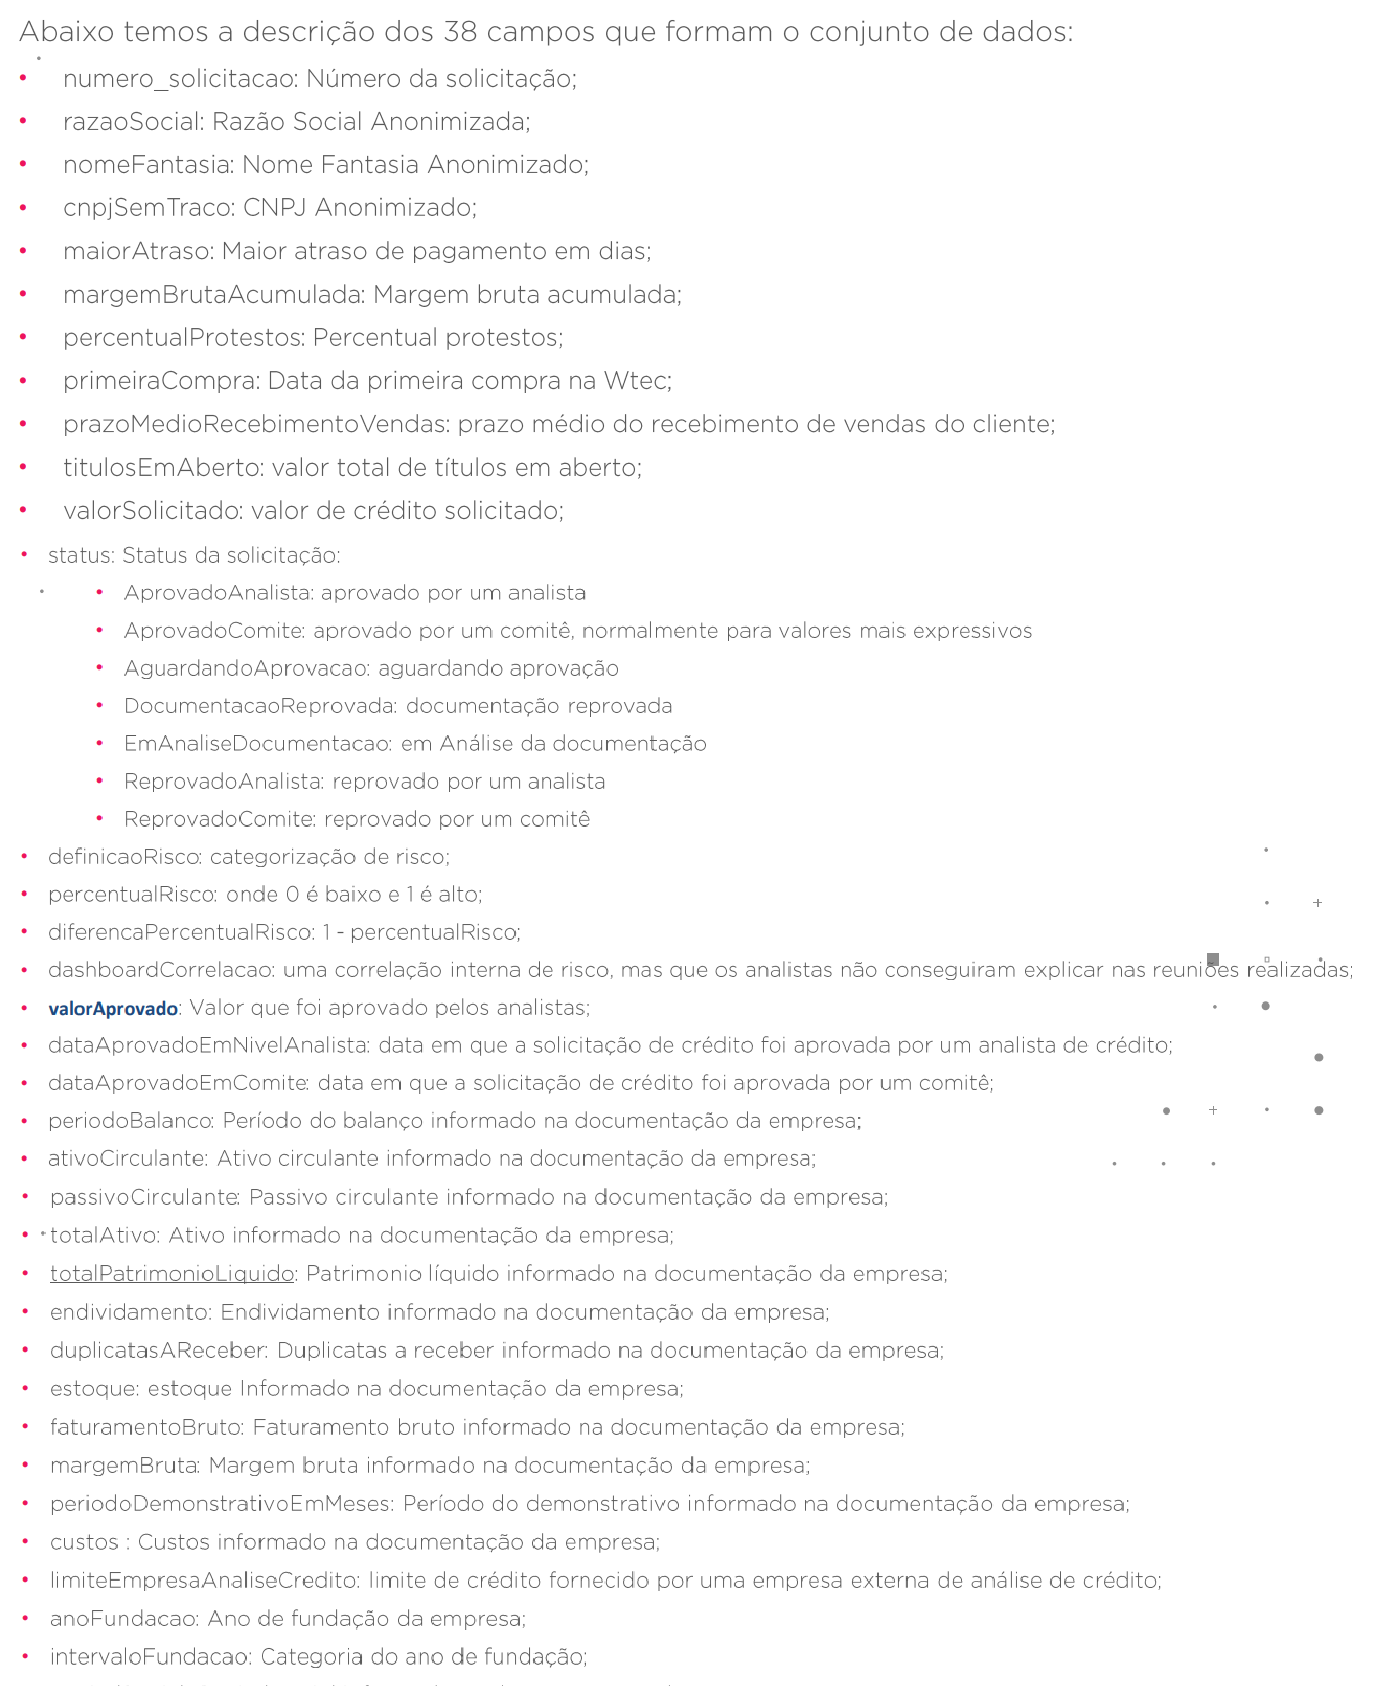

## Lógica usada neste trabalho
Existem dois problemas principais neste dataset:
    - Muitos nulos
    - Algumas variáveis não são 'inputáveis'
    - Alta correlação entre colunas
Portanto, será necessário realizar uma redução de dimensionalidade, primeiramente em colunas que sejam resultados calculados de análises feitas fora do escopo deste trabalho.

### Fluxo:
1. Redução da dimensionalidade em colunas que expressem dados de outros processos
2. Feature engineering 
3. Análise de colunas categóricas
4. Tratamento de nulos
5. Validação de feature importance
6. Redução de dimensionalidade com base na feature importance (para modelo preditivo)
7. Segmentação do dataframe
8. Análise de características dos clusters
9. Modelos preditivos por cluster


In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import json
import datetime
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('bootcamp-solicitacoescredito.csv')
pd.set_option('display.max_columns', df.shape[1])
pd.set_option('display.max_rows', 50)

df

,numero_solicitacao,razaoSocial,nomeFantasia,cnpjSemTraco,maiorAtraso,margemBrutaAcumulada,percentualProtestos,primeiraCompra,prazoMedioRecebimentoVendas,titulosEmAberto,valorSolicitado,status,definicaoRisco,diferencaPercentualRisco,percentualRisco,dashboardCorrelacao,valorAprovado,dataAprovadoEmComite,periodoBalanco,ativoCirculante,passivoCirculante,totalAtivo,totalPatrimonioLiquido,endividamento,duplicatasAReceber,estoque,faturamentoBruto,margemBruta,periodoDemonstrativoEmMeses,custos,anoFundacao,intervaloFundacao,capitalSocial,restricoes,empresa_MeEppMei,scorePontualidade,limiteEmpresaAnaliseCredito,dataAprovadoNivelAnalista
0,1,James Richardson-Patel,Alexandra Williams,KEBE17609492220843,0,0.252448,0.0,2015-12-10T00:00:00,0,0.00,50000.0,AprovadoAnalista,De 11 a 30 % - Baixo,0.716981,0.283019,0.000000,50000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1766880.0,0.0,12.0,0.0,2003.0,Acima de 17 anos,90000.0,False,True,1.000000,43200.0,2020-02-03T20:57:33
1,2,Dr. Geoffrey Walsh,Mr. Darren Arnold,JRBK88908250677300,0,0.000000,NaN,2019-06-12T17:28:31,0,0.00,10000.0,DocumentacaoReprovada,De 0 a 10 % - Muito Baixo,1.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
2,3,Joanna Hudson,Dr. David Rees,GCVQ28531614261293,4,0.624777,0.0,2019-11-27T00:00:00,0,0.00,20000.0,AprovadoAnalista,De 11 a 30 % - Baixo,0.716981,0.283019,0.000000,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2814940.0,0.0,7.0,0.0,2014.0,De 6 a 10 anos,20000.0,False,True,1.000000,4320.0,2020-02-04T16:40:49
3,4,Gordon Jones-Hopkins,Sara Reid-Robson,KJND32266018316396,20,0.000000,NaN,2017-02-13T17:20:27,0,0.00,25000.0,AprovadoAnalista,De 51 a 80 % - Alto,0.396226,0.603774,0.485811,15000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1285274.0,0.0,12.0,0.0,2013.0,De 6 a 10 anos,30000.0,False,True,0.000000,5920.0,2020-02-04T16:37:52
4,5,Nigel Lee,Dr. Stanley Duncan,CGQN15826802440348,20,0.454088,0.0,2010-07-13T00:00:00,20,1486.95,50000.0,AprovadoAnalista,De 11 a 30 % - Baixo,0.830189,0.169811,0.000000,50000.0,NaN,2019-09-30T00:00:00,14758917.0,12149031.0,25793410.0,14544378.0,3039112.0,11797928.0,3047791.0,40779757.0,81459809.0,9.0,40680051.0,2002.0,Acima de 17 anos,75000.0,False,False,1.000000,89000.0,2020-02-04T15:06:28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8968,9041,Leah Williams,Georgia Booth,YKGZ02907098931653,149,0.306580,0.0,2006-04-26T00:00:00,59,599964.04,900000.0,EmAnaliseDocumentacao,De 0 a 10 % - Muito Baixo,1.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.990876,NaN,NaN
8969,9042,Mr. Jordan Stevens,Miss Ellie Kelly,UCBM91111020900951,23,0.329796,0.0,2016-08-03T00:00:00,0,0.00,150000.0,EmAnaliseDocumentacao,De 0 a 10 % - Muito Baixo,1.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.958869,NaN,NaN
8970,9043,Mr. Barry Wells,Danielle Hudson,CLDB61185288622179,3,0.383919,0.0,2018-10-25T00:00:00,4,2933.38,150000.0,EmAnaliseDocumentacao,De 0 a 10 % - Muito Baixo,1.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN
8971,9044,Keith Jones,Steven Kennedy-Jones,BRJP37453437154592,11,0.424099,0.0,2011-08-10T00:00:00,31,559679.98,1290000.0,EmAnaliseDocumentacao,De 0 a 10 % - Muito Baixo,1.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.994786,NaN,NaN


In [3]:
#carregando dicionário de dados
with open ('descricao_colunas.json', 'r') as jsonfile:
    dict_desc_colunas = json.load(jsonfile)
for item in sorted(dict_desc_colunas):
    print (item+':', dict_desc_colunas[item])

anoFundacao: Ano de fundação da empresa
ativoCirculante: Ativo circulante informado na documentação da empresa
capitalSocial: Capital social informado na documentação da empresa
cnpjSemTraco: CNPJ Anonimizado
custos: Custos informado na documentação da empresa
dashboardCorrelacao: uma correlação interna de risco, mas que os analistas não conseguiram explicar nas reuniões realizadas
dataAprovadoEmComite: data em que a solicitação de crédito foi aprovada por um comitê
dataAprovadoNivelAnalista: data em que a solicitação de crédito foi aprovada por um analista de crédito
definicaoRisco: categorização de risco
diferencaPercentualRisco: 1- percentual Risco
duplicatasAReceber: Duplicatas a receber informado na documentação da empresa
empresa_MeEppMei: Flag informando se o cliente é um pequeno negócio
endividamento: Endividamento informado na documentação da empresa
estoque: estoque Informado na documentação da empresa
faturamentoBruto: Faturamento bruto informado na documentação da empresa
i

In [4]:
print ('Porcentagem de valores cedidos em relação a solicitados:',
       round((df['valorAprovado']/df['valorSolicitado']).mean(),2))

Porcentagem de valores cedidos em relação a solicitados: 0.83


### Dimensionalidade e Correlação
Verificando a possibilidade de dropar colunas com alta correlação e que não atendem a necessidade de propor valor de crédito de forma automatizada, reduzindo o dataset.

###### __mapeando correlações__

ρ = 0,9 a 1 (positivo ou negativo): correlação muito forte;

ρ = 0,7 a 09 (positivo ou negativo): correlação forte;

ρ = 0,5 a 0,7 (positivo ou negativo): correlação moderada;

ρ = 0,3 a 0,5 (positivo ou negativo): correlação fraca;

ρ = 0 a 0,3 (positivo ou negativo): não possui correlação.

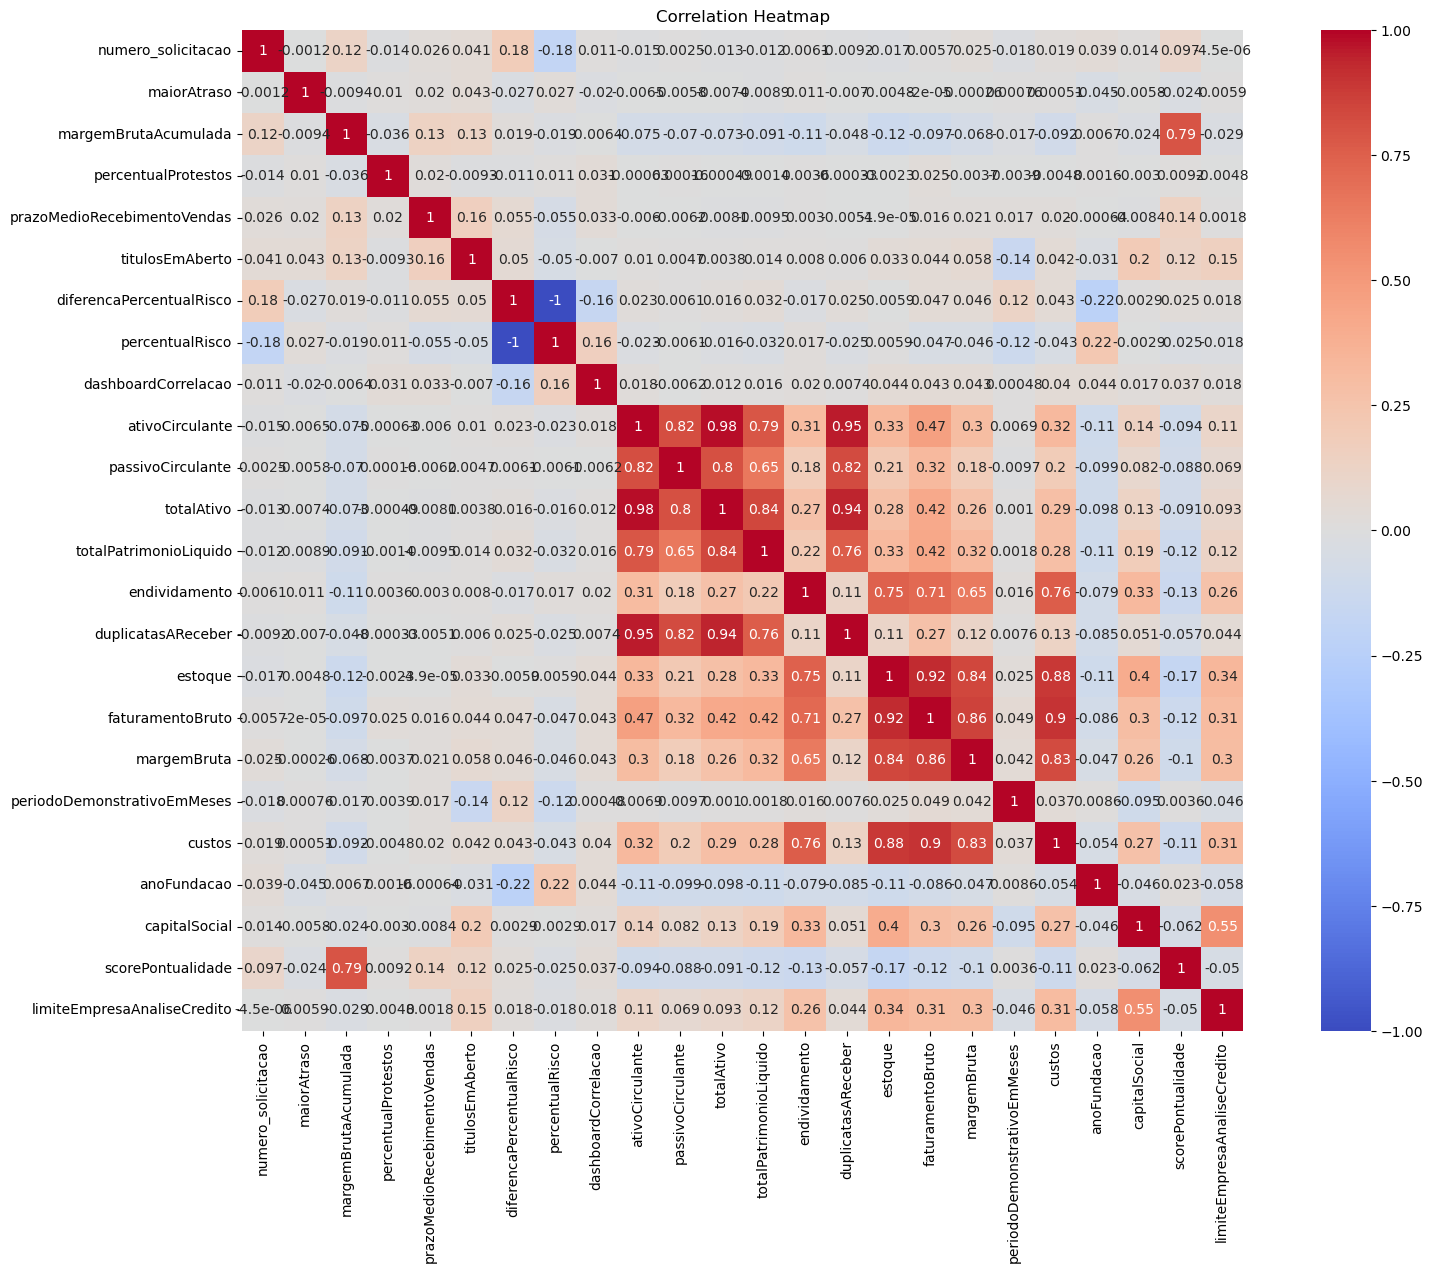

In [5]:
#verificando alta correlação em variáveis independentes
# dropando valorSolicitado da análise por ser dado de entrada muito importante
def verifica_correlacao(df):
    corr_matrix = df.drop(columns=['valorSolicitado','valorAprovado']).corr() 
    plt.figure(figsize=(20, 13))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True)
    plt.title('Correlation Heatmap')
    plt.show()
    return corr_matrix
corr_matrix = verifica_correlacao(df)

Notamos acima muitas colunas com alta correlação. Veremos quais são.

In [6]:
#buscando maiores correlações
colunas_alta_correlacao = {}
for row_idx, row in corr_matrix.iterrows():
    dict_row = {}
    for col in corr_matrix.columns:
        if col != row_idx:
            dict_row.update({row[col]:col})
    score_correlacao_ascendente = []
    for corr_score in sorted(dict_row, reverse=True):
        score_correlacao_ascendente.append(dict_row[corr_score])
    colunas_alta_correlacao.update({row_idx:score_correlacao_ascendente})
df_correlacao_ordenada = pd.DataFrame.from_dict(colunas_alta_correlacao).T
df_correlacao_ordenada = df_correlacao_ordenada[[0,1,2]]
df_correlacao_ordenada.sort_index(inplace=True)
df_correlacao_ordenada.columns = ['maior', 'segunda_maior', 'terceira_maior']
df_correlacao_ordenada

,maior,segunda_maior,terceira_maior
anoFundacao,percentualRisco,dashboardCorrelacao,numero_solicitacao
ativoCirculante,totalAtivo,duplicatasAReceber,passivoCirculante
capitalSocial,limiteEmpresaAnaliseCredito,estoque,endividamento
custos,faturamentoBruto,estoque,margemBruta
dashboardCorrelacao,percentualRisco,estoque,anoFundacao
diferencaPercentualRisco,numero_solicitacao,periodoDemonstrativoEmMeses,prazoMedioRecebimentoVendas
duplicatasAReceber,ativoCirculante,totalAtivo,passivoCirculante
endividamento,custos,estoque,faturamentoBruto
estoque,faturamentoBruto,custos,margemBruta
faturamentoBruto,estoque,custos,margemBruta


###### __Vamos então dropar as seguintes:__
* ativoCirculante - parece estar melhor representada pelo totalAtivo
* passivoCirculante - muita correlação com ativoCirculante
* estoque - tem alta correlação com capitalSocial e faturamentoBruto
* custos - tem alta correlação com capitalSocial e faturamentoBruto
* duplicatasAReceber - tem alta correlação com totalAtivo
* totalPatrimonioLiquido - muita correlação com totalAtivo 
* endividamento - muita correlação com faturamentoBruto
* margemBruta - muita correlação com faturamentoBruto
* numero_solicitacao - número de linha, não faz sentido para ML. - _Este dado será mantido para a etapa seguinte e então dropado_.
* razaoSocial - CNPJ é PK
* nomeFantasia - CNPJ é PK
* maiorAtraso - dado impossível de inputar para novos clientes
* margemBrutaAcumulada - não faz sentido para ML
* percentualProtestos - baseado em dado externo
* status - baseado em dado externo
* definicaoRisco - baseado em dado externo
* diferencaPercentualRisco - baseado em dado externo
* percentualRisco - baseado em dado externo
* dashboardCorrelacao - baseado em dado externo
* dataAprovadoEmComite - baseado em dado externo
* anoFundacao - existe coluna categórica intervaloFundacao que permitiria segmentacao
* restricoes - baseado em dado externo
* scorePontualidade - baseado em dado externo
* limiteEmpresaAnaliseCredito - baseado em dado externo
* dataAprovadoNivelAnalista - baseado em dado externo
* dataAprovadoNivelAnalista - baseado em dado externo

In [7]:
df = pd.read_csv('bootcamp-solicitacoescredito.csv')
a_dropar = [
            'ativoCirculante',
            'passivoCirculante',
            'estoque',
            'custos',
            'duplicatasAReceber',
            'totalPatrimonioLiquido',
            'endividamento',
            'margemBruta',
            'razaoSocial',
            'nomeFantasia',
            'maiorAtraso',
            'margemBrutaAcumulada',
            'percentualProtestos',
            'status',
            'definicaoRisco',
            'diferencaPercentualRisco',
            'percentualRisco',
            'dashboardCorrelacao',
            'dataAprovadoEmComite',
            'anoFundacao',
            'restricoes',
            'scorePontualidade',
            'limiteEmpresaAnaliseCredito',
            'dataAprovadoNivelAnalista',
            'dataAprovadoNivelAnalista'
            ]

for col in sorted(a_dropar):
    print ('DROP '+col+' --  ' + dict_desc_colunas[col])

df = df.drop(columns=a_dropar)

DROP anoFundacao --  Ano de fundação da empresa
DROP ativoCirculante --  Ativo circulante informado na documentação da empresa
DROP custos --  Custos informado na documentação da empresa
DROP dashboardCorrelacao --  uma correlação interna de risco, mas que os analistas não conseguiram explicar nas reuniões realizadas
DROP dataAprovadoEmComite --  data em que a solicitação de crédito foi aprovada por um comitê
DROP dataAprovadoNivelAnalista --  data em que a solicitação de crédito foi aprovada por um analista de crédito
DROP dataAprovadoNivelAnalista --  data em que a solicitação de crédito foi aprovada por um analista de crédito
DROP definicaoRisco --  categorização de risco
DROP diferencaPercentualRisco --  1- percentual Risco
DROP duplicatasAReceber --  Duplicatas a receber informado na documentação da empresa
DROP endividamento --  Endividamento informado na documentação da empresa
DROP estoque --  estoque Informado na documentação da empresa
DROP limiteEmpresaAnaliseCredito --  lim

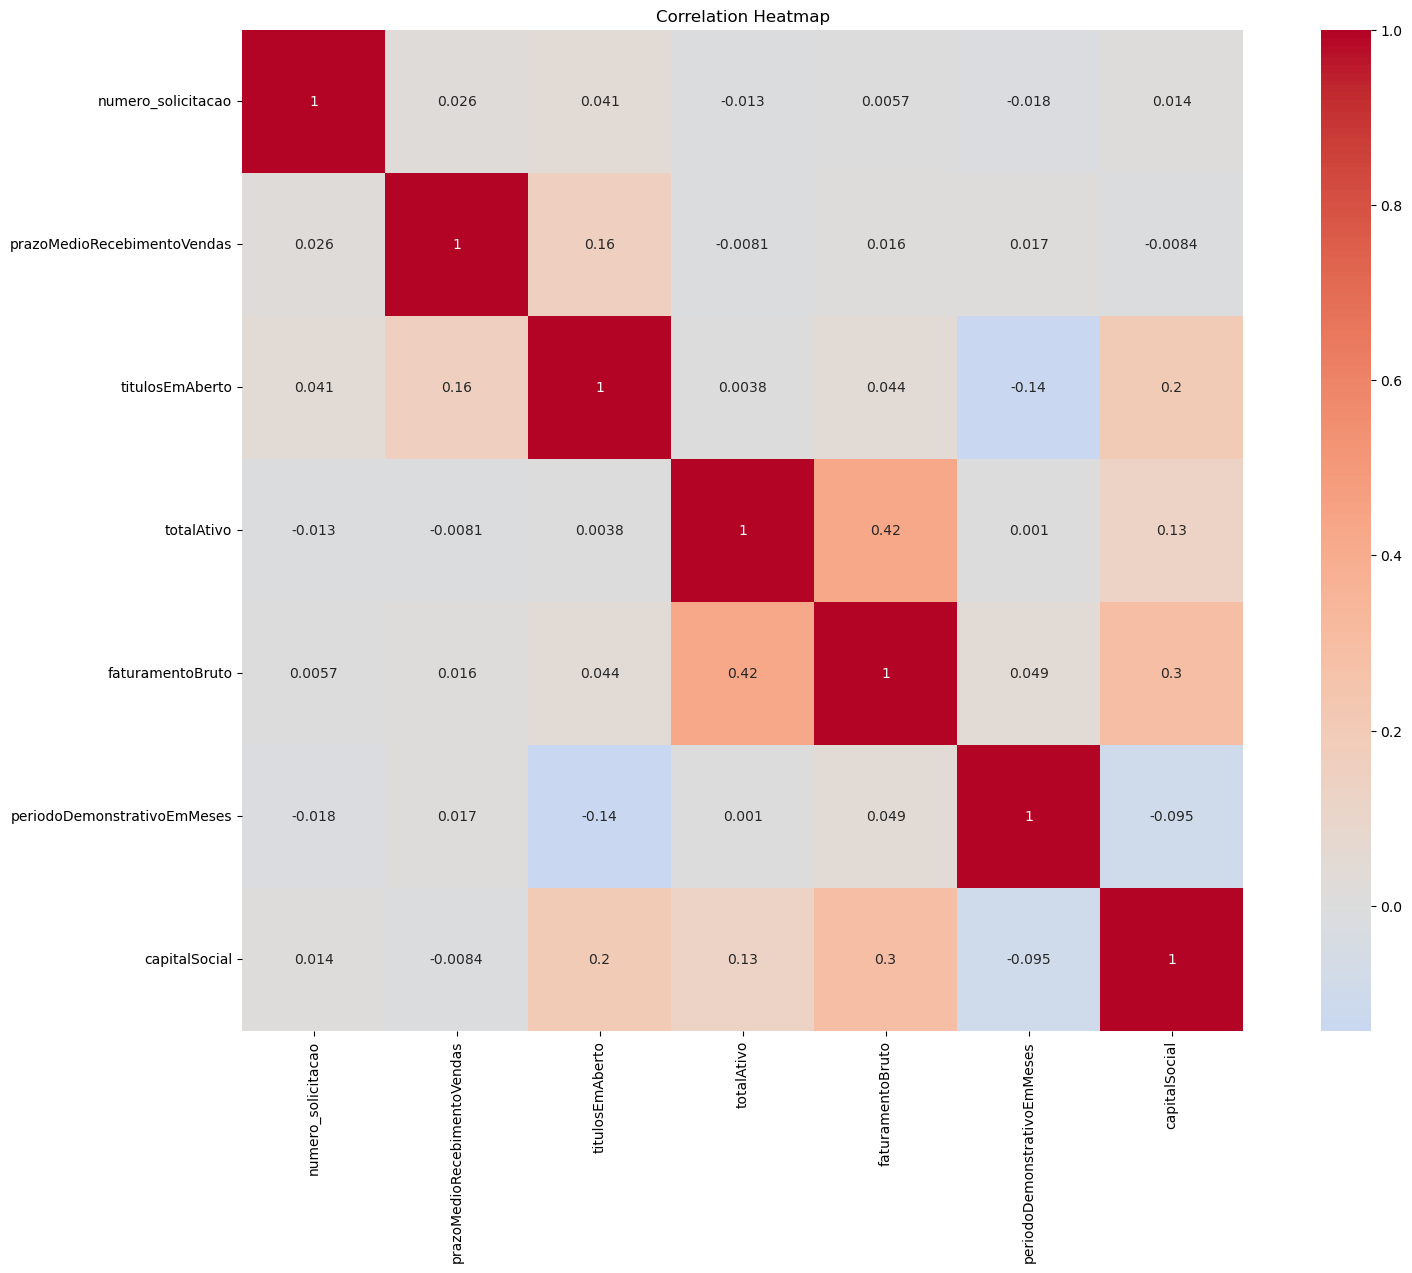

In [8]:
# observando df após drop
corr_matrix = verifica_correlacao(df)

In [9]:
#colunas que ficaram
for col in sorted(df.columns):
    print (col+' --  ' + dict_desc_colunas[col])

capitalSocial --  Capital social informado na documentação da empresa
cnpjSemTraco --  CNPJ Anonimizado
empresa_MeEppMei --  Flag informando se o cliente é um pequeno negócio
faturamentoBruto --  Faturamento bruto informado na documentação da empresa
intervaloFundacao --  Categoria do ano de fundação
numero_solicitacao --  Número da solicitação
periodoBalanco --  Período do balanço informado na documentação da empresa
periodoDemonstrativoEmMeses --  Período do demonstrativo informado na documentação da empresa
prazoMedioRecebimentoVendas --  prazo médio do recebimento de vendas do cliente
primeiraCompra --  Data da primeira compra na Wtec
titulosEmAberto --  valor total de títulos em aberto
totalAtivo --  Ativo informado na documentação da empresa
valorAprovado --  Valor que foi aprovado pelos analistas
valorSolicitado --  valor de crédito solicitado


### Nulos
Verificando a possibilidade de aproveitar um dado não-nulo de uma empresa (de uma solicitação de crédito) em uma linha que tenha este mesmo dado nulo (em outra solicitação)

In [10]:
#nulos
df.isna().sum()/df.shape[0]

numero_solicitacao             0.000000
cnpjSemTraco                   0.000000
primeiraCompra                 0.011813
prazoMedioRecebimentoVendas    0.000000
titulosEmAberto                0.000000
valorSolicitado                0.000000
valorAprovado                  0.156469
periodoBalanco                 0.472529
totalAtivo                     0.472529
faturamentoBruto               0.083584
periodoDemonstrativoEmMeses    0.083584
intervaloFundacao              0.083027
capitalSocial                  0.083027
empresa_MeEppMei               0.083027
dtype: float64

Vamos tratar a variável resposta e eliminar os NaN's passando o valor 0.

In [11]:
#substituindo nulos da variável resposta
df['valorAprovado'] = df['valorAprovado'].fillna(0)

Observando empresas com nulos

In [12]:
#verificando se alguns dos dados nulos estão sob o mesmo CNPJ em outras linhas
empresas = df['cnpjSemTraco'].unique()
print (str(len(empresas))+' empresas no dataset')
indice_sem_balanco = df.loc[(df['totalAtivo'].isnull())].index
contagem_por_empresa = df['cnpjSemTraco'].value_counts()
nulos_por_empresa_campo = df[['cnpjSemTraco','totalAtivo']]
nulos_por_empresa_campo['null'] = ~nulos_por_empresa_campo['totalAtivo']\
                                            .notnull()\
                                            .astype(bool)
nulos_por_empresa_campo = nulos_por_empresa_campo.drop(columns = ['totalAtivo'])


nulos_por_empresa = nulos_por_empresa_campo.groupby(by='cnpjSemTraco').sum()
nulos_por_empresa['contagem_por_empresa'] = contagem_por_empresa
nulos_por_empresa['pct_nulos_totalAtivo'] = nulos_por_empresa['null'] / \
                                        nulos_por_empresa['contagem_por_empresa']
nulos_por_empresa[(nulos_por_empresa['pct_nulos_totalAtivo']>0) & (nulos_por_empresa['pct_nulos_totalAtivo']<1)]\
                    .sort_values('pct_nulos_totalAtivo', ascending = False)

2829 empresas no dataset


,null,contagem_por_empresa,pct_nulos_totalAtivo
cnpjSemTraco,,,
LPFJ21465680706778,10,11,0.909091
CKWJ48521633259803,9,10,0.900000
FOZQ39728582407424,8,9,0.888889
CXIG28465604067668,7,8,0.875000
DCYQ25190726049709,7,8,0.875000
...,...,...,...
PWKB17417173046971,1,13,0.076923
ARLG39955776479526,1,14,0.071429
DSDP42915296213541,1,16,0.062500


In [13]:
empresa_exemplo = df[df['cnpjSemTraco']=='PWKB17417173046971'].T
empresa_exemplo.loc['faturamentoBruto']

1410    239016696.0
1441    239016696.0
2002    203852000.0
3713    116888249.0
4209    116888249.0
4651    116888249.0
5006    149238970.0
5492    149238970.0
5499    149238970.0
7179    149238970.0
7220    149238970.0
8702            NaN
8706    316111426.0
Name: faturamentoBruto, dtype: object

Reordenando dataframe por empresa e número de solicitação e tratando NaN com backfill

In [14]:
#reordenando dataframe
df = df.sort_values(['cnpjSemTraco', 'numero_solicitacao'])\
                    .reset_index(drop=True).drop(columns = 'numero_solicitacao')
#quebrando dataframe em dicionarios
dict_empresas = {}
for empresa in empresas:
    dict_empresas.update({empresa:df[df['cnpjSemTraco']==empresa]})
#realizando o fillna por empresa usando ffill
for empresa in dict_empresas:
    dict_empresas[empresa] = dict_empresas[empresa].fillna(method='ffill')
#reconstruindo dataframe
lista_df = []
for empresa in dict_empresas:
    dict_empresas[empresa] = dict_empresas[empresa].fillna(method='ffill')
    lista_df.append(dict_empresas[empresa])
df2 = pd.concat(lista_df)
df2

,cnpjSemTraco,primeiraCompra,prazoMedioRecebimentoVendas,titulosEmAberto,valorSolicitado,valorAprovado,periodoBalanco,totalAtivo,faturamentoBruto,periodoDemonstrativoEmMeses,intervaloFundacao,capitalSocial,empresa_MeEppMei
3696,KEBE17609492220843,2015-12-10T00:00:00,0,0.0,50000.0,50000.0,NaN,NaN,1766880.0,12.0,Acima de 17 anos,90000.0,True
3697,KEBE17609492220843,2015-12-10T00:00:00,0,0.0,100000.0,65000.0,2019-12-31T03:00:00,1876039.0,1818311.0,12.0,Acima de 17 anos,90000.0,True
3698,KEBE17609492220843,2015-12-10T00:00:00,0,0.0,120000.0,65000.0,2019-12-31T03:00:00,1876039.0,1818311.0,12.0,Acima de 17 anos,90000.0,True
3699,KEBE17609492220843,2015-12-10T00:00:00,0,0.0,100000.0,65000.0,2019-12-31T03:00:00,1876039.0,1818311.0,12.0,Acima de 17 anos,90000.0,True
3548,JRBK88908250677300,2019-06-12T17:28:31,0,0.0,10000.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
898,CLOG87874305102258,2021-02-08T00:00:00,15,10080.0,200000.0,50000.0,NaN,NaN,2924092.0,12.0,De 0 a 5 anos,300000.0,True
1270,DMNU57577101368941,2007-03-01T00:00:00,0,0.0,35000.0,30000.0,NaN,NaN,1684508.0,12.0,Acima de 17 anos,10000.0,False
3682,KBOS63147302240824,2017-02-13T16:41:03,0,0.0,50000.0,45000.0,NaN,NaN,3410070.0,12.0,De 6 a 10 anos,200000.0,False
3261,ISPY81393760117061,2019-05-16T00:00:00,0,0.0,200000.0,15000.0,2019-12-31T03:00:00,2336218.0,1366363.0,12.0,De 0 a 5 anos,100000.0,True


In [15]:
# observando resultados
df2_nulos = (df2.isna().sum()/df.shape[0]).sort_values(ascending = False)
df2_nulos = pd.concat([df.isna().sum()/df.shape[0],df2_nulos], axis=1)
df2_nulos.columns = ['df1', 'df2']
print ('Redução de nulos em', str(round((1-(df2_nulos['df2'].sum()/df2_nulos['df1'].sum()))*100,2))+'%.')
df2_nulos


Redução de nulos em 30.9%.


,df1,df2
cnpjSemTraco,0.000000,0.000000
primeiraCompra,0.011813,0.011702
prazoMedioRecebimentoVendas,0.000000,0.000000
titulosEmAberto,0.000000,0.000000
valorSolicitado,0.000000,0.000000
valorAprovado,0.000000,0.000000
periodoBalanco,0.472529,0.407556
totalAtivo,0.472529,0.407556
faturamentoBruto,0.083584,0.024407
periodoDemonstrativoEmMeses,0.083584,0.024407


###### _Como podemos ver acima, a quantidade de nulos no df2 foi reduzida em 30.9%._

Vamos rodar algoritmos de clusterização, inserir os labels no dataframe e então terminar de tratar NaN's com médias por cluster.

### Feature Engineering

###### _transformando datas_
As datas estão no formato data-hora-minuto-segundo, vamos transformalas em colunas apartadas

In [16]:
def split_datas(df, cols):
    df = df.copy()
    for col in cols:
        for ymd in ['Y', 'm']:
            df[col+'_'+ymd] = df.loc[df[col].notnull(), col] \
                .apply(lambda x: int(datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S') \
                .strftime('%'+ymd)))
    df.drop(columns=cols, inplace=True)
    return df
df2 = split_datas(df2, ['primeiraCompra', 'periodoBalanco'])

###### _inserindo quantidades de solicitações de crédito_

In [17]:
df2["qtd_solic"] = df.groupby('cnpjSemTraco')['cnpjSemTraco'].rank(method="first", ascending=True)
df2[['cnpjSemTraco', 'qtd_solic']].head(10)

,cnpjSemTraco,qtd_solic
3696,KEBE17609492220843,1.0
3697,KEBE17609492220843,2.0
3698,KEBE17609492220843,3.0
3699,KEBE17609492220843,4.0
3548,JRBK88908250677300,1.0
2164,GCVQ28531614261293,1.0
2165,GCVQ28531614261293,2.0
2166,GCVQ28531614261293,3.0
2167,GCVQ28531614261293,4.0
2168,GCVQ28531614261293,5.0


Antes da clusterização, precisamos aumentar o grão em um nível, de forma que cada linha expresse uma empresa. Isso facilitará na análise de clusters e permitirá que tratemos os NaN's ainda presentes com informações dos clusters.

Para isso, vamos então realizar o Label Encoding das variáveis do tipo Object para então agrupar em empresas usando a média das variáveis e rodar a clusterização.

In [18]:
def label_encode_write_json(df,ignore_cols = None, name = None):
    # transformando o dataframe com label encoder
    cols = list(df.columns)
    if ignore_cols != None:
        if type(ignore_cols) != list:
            ignore_cols = [ignore_cols]
        cols = set(cols)-set(ignore_cols)
    le = LabelEncoder()
    dict_label_encoder = {}
    for col in cols:
        if df[col].dtype == 'object':
            le.fit(df[col])
            df[col] = le.transform(df[col])
            for val in df[col].drop_duplicates():
                try:
                    dict_label_encoder[col].update({le.inverse_transform([val])[0]:val})
                except:
                    dict_label_encoder.update({col:{le.inverse_transform([val])[0]:val}})
    if name != None:
        try:
            os.mkdir('Models')
        except:
            pass
        with open ('Models/label_encode_{name}.json'.format(name=name), 'w') as jsonfile:
            json.dump(dict_label_encoder, jsonfile)         
    return df

In [19]:
#construindo df_empresas
df_empresas = df2.copy()

#removendo colunas pouco pertinentes à 'persona' das emprsas
df_empresas = df_empresas.drop(columns = ['valorAprovado',
                                          'primeiraCompra_Y',
                                          'primeiraCompra_m',
                                          'periodoBalanco_Y',
                                          'periodoBalanco_m',
                                          'valorSolicitado'])

#label encoding e criação de inverse_transform para futuros clientes
df_empresas = label_encode_write_json(df_empresas, ignore_cols = 'cnpjSemTraco', name = '{cnt}col'\
                                                                  .format(cnt = df_empresas.shape[1]))
df_empresas

,cnpjSemTraco,prazoMedioRecebimentoVendas,titulosEmAberto,totalAtivo,faturamentoBruto,periodoDemonstrativoEmMeses,intervaloFundacao,capitalSocial,empresa_MeEppMei,qtd_solic
3696,KEBE17609492220843,0,0.0,NaN,1766880.0,12.0,0,90000.0,1,1.0
3697,KEBE17609492220843,0,0.0,1876039.0,1818311.0,12.0,0,90000.0,1,2.0
3698,KEBE17609492220843,0,0.0,1876039.0,1818311.0,12.0,0,90000.0,1,3.0
3699,KEBE17609492220843,0,0.0,1876039.0,1818311.0,12.0,0,90000.0,1,4.0
3548,JRBK88908250677300,0,0.0,NaN,NaN,NaN,4,NaN,2,1.0
...,...,...,...,...,...,...,...,...,...,...
898,CLOG87874305102258,15,10080.0,NaN,2924092.0,12.0,1,300000.0,1,1.0
1270,DMNU57577101368941,0,0.0,NaN,1684508.0,12.0,0,10000.0,0,1.0
3682,KBOS63147302240824,0,0.0,NaN,3410070.0,12.0,3,200000.0,0,1.0
3261,ISPY81393760117061,0,0.0,2336218.0,1366363.0,12.0,1,100000.0,1,1.0


In [20]:
#agrupando dataframe
df_empresas = df_empresas.groupby('cnpjSemTraco').agg({
    'prazoMedioRecebimentoVendas':'mean',
    'titulosEmAberto':'mean',
    'totalAtivo':'max',
    'faturamentoBruto':'max',
    'periodoDemonstrativoEmMeses':'mean',
    'intervaloFundacao':'max',
    'capitalSocial':'mean',
    'empresa_MeEppMei':'max',
    'qtd_solic':'max'
})

##### Clusterização
Utilizando o DBSCAN, KMeans e GaussianMixture para realizar clusterização do dataset df_empresas

In [21]:
#ainda existem nulos
df_empresas.isna().sum()

prazoMedioRecebimentoVendas       0
titulosEmAberto                   0
totalAtivo                     1306
faturamentoBruto                 40
periodoDemonstrativoEmMeses      40
intervaloFundacao                 0
capitalSocial                    40
empresa_MeEppMei                  0
qtd_solic                         0
dtype: int64

Tratando nulos restantes

In [22]:
print ('linhas atuais',df_empresas.shape[0],'\nlinhas dropna', df_empresas.dropna().shape[0])

linhas atuais 2829 
linhas dropna 1523


Ao usar o DROPNA, perderíamos muitas linhas. Como as informações faltantes no dataset de Empresas são de Ativo e de Capital Social, vamos verificar o que ocorre com os valores cedidos para empresas sem estas informações:

In [23]:
#total de crédito concedido para empresas com capitalSocial nulo
df[df['capitalSocial'].isna()]['valorAprovado'].astype(float).sum()

0.0

In [24]:
#total de crédito concedido para empresas com totalAtivo nulo
df[df['totalAtivo'].isna()]['valorAprovado'].astype(float).sum()

253344534.0

Portanto, é possível entender que seja uma **regra de negócios** haver informação de capitalSocial, porém não de totalAtivo.
Por conta disso, vamos **dropar** as linhas sem capitalSocial e transformar as NaN's de totalAtivo em 0 antes de realizar a clusterização.

De qualquer forma, a proposta é que **todas** as informações solicitadas sejam repassadas pelo cliente, e isso será reforçado pelo front-end da aplicação.

In [25]:
df_empresas.dropna(subset=['capitalSocial'], inplace = True)
df_empresas['totalAtivo'].fillna(0, inplace=True)

In [26]:
#confirmando não haverem nulos
for col in df_empresas.columns:
    df_empresas[col].fillna(df_empresas[col].mean(), inplace=True)
df_empresas.isna().sum()

prazoMedioRecebimentoVendas    0
titulosEmAberto                0
totalAtivo                     0
faturamentoBruto               0
periodoDemonstrativoEmMeses    0
intervaloFundacao              0
capitalSocial                  0
empresa_MeEppMei               0
qtd_solic                      0
dtype: int64

In [27]:
#dropando coluna de cnpj (indice)
df_empresas_com_cnpj = df_empresas.copy() # para uso posterior
df_empresas = df_empresas.reset_index(drop=True)

### DBSCAN

In [28]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=3, min_samples=3)
dbscan.fit(df_empresas)
df_empresas_dbscan = df_empresas.copy()
df_empresas_dbscan['label'] = dbscan.labels_
print (len(df_empresas_dbscan['label'].unique()), 'clusters')
df_empresas_dbscan['label'].value_counts()/df_empresas_dbscan.shape[0]*100

13 clusters


-1     98.314808
 3      0.215131
 11     0.215131
 9      0.179276
 1      0.143421
 2      0.143421
 4      0.143421
 0      0.107565
 5      0.107565
 6      0.107565
 7      0.107565
 8      0.107565
 10     0.107565
Name: label, dtype: float64

Notamos acima que o DBSCAN gerou representatividade muito baixa em clusters que não o -1.

In [29]:
df_empresas_dbscan

,prazoMedioRecebimentoVendas,titulosEmAberto,totalAtivo,faturamentoBruto,periodoDemonstrativoEmMeses,intervaloFundacao,capitalSocial,empresa_MeEppMei,qtd_solic,label
0,0.0,58080.00,27583488.0,23429595.0,12.000000,0,2.500000e+05,1,8.0,-1
1,0.0,12780.00,0.0,3725867.0,7.600000,3,6.000000e+04,1,5.0,-1
2,0.0,0.00,1828274.0,2213365.0,12.000000,0,1.200000e+05,0,7.0,-1
3,31.0,56267.50,13163240.0,17823997.0,11.833333,4,5.333333e+05,2,7.0,-1
4,0.0,0.00,868327.0,2804091.0,12.000000,2,3.000000e+04,1,2.0,-1
...,...,...,...,...,...,...,...,...,...,...
2784,0.0,0.00,0.0,745756.0,12.000000,3,4.000000e+04,1,1.0,-1
2785,38.0,40887.77,96091171.0,68644820.0,9.000000,0,1.500000e+07,0,4.0,-1
2786,58.0,12453.57,906427.0,973841.0,12.000000,1,4.000000e+05,0,4.0,-1
2787,0.0,0.00,0.0,3388114.0,9.000000,1,2.000000e+05,0,1.0,-1


### K-Means

In [30]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, 
                max_iter=1000,
                tol=1e-4)

y_kmeans = kmeans.fit_predict(df_empresas)
df_empresas_kmeans = df_empresas.copy()
df_empresas_kmeans['label'] = y_kmeans
print (len(df_empresas_kmeans['label'].unique()), 'clusters')
df_empresas_kmeans['label'].value_counts()/df_empresas_kmeans.shape[0]*100

3 clusters


0    99.426318
2     0.537827
1     0.035855
Name: label, dtype: float64

In [31]:
df_empresas_kmeans

,prazoMedioRecebimentoVendas,titulosEmAberto,totalAtivo,faturamentoBruto,periodoDemonstrativoEmMeses,intervaloFundacao,capitalSocial,empresa_MeEppMei,qtd_solic,label
0,0.0,58080.00,27583488.0,23429595.0,12.000000,0,2.500000e+05,1,8.0,0
1,0.0,12780.00,0.0,3725867.0,7.600000,3,6.000000e+04,1,5.0,0
2,0.0,0.00,1828274.0,2213365.0,12.000000,0,1.200000e+05,0,7.0,0
3,31.0,56267.50,13163240.0,17823997.0,11.833333,4,5.333333e+05,2,7.0,0
4,0.0,0.00,868327.0,2804091.0,12.000000,2,3.000000e+04,1,2.0,0
...,...,...,...,...,...,...,...,...,...,...
2784,0.0,0.00,0.0,745756.0,12.000000,3,4.000000e+04,1,1.0,0
2785,38.0,40887.77,96091171.0,68644820.0,9.000000,0,1.500000e+07,0,4.0,0
2786,58.0,12453.57,906427.0,973841.0,12.000000,1,4.000000e+05,0,4.0,0
2787,0.0,0.00,0.0,3388114.0,9.000000,1,2.000000e+05,0,1.0,0


Situação similar no KMeans

### GaussianMixture

In [32]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=3, 
                     max_iter=1000, 
                     tol=1e-4,
                     init_params='random')
y_gm = gm.fit_predict(df_empresas)
df_empresas_gm = df_empresas.copy()
df_empresas_gm['label'] = y_gm
print (len(df_empresas_gm['label'].unique()), 'clusters')
df_empresas_gm['label'].value_counts()/df_empresas_gm.shape[0]*100

3 clusters


0    65.543205
1    32.126210
2     2.330584
Name: label, dtype: float64

Com GaussianMixture notamos uma distribuição melhor. Vamos analisar os clusters com base nas features.

In [33]:
df_empresas_gm

,prazoMedioRecebimentoVendas,titulosEmAberto,totalAtivo,faturamentoBruto,periodoDemonstrativoEmMeses,intervaloFundacao,capitalSocial,empresa_MeEppMei,qtd_solic,label
0,0.0,58080.00,27583488.0,23429595.0,12.000000,0,2.500000e+05,1,8.0,1
1,0.0,12780.00,0.0,3725867.0,7.600000,3,6.000000e+04,1,5.0,1
2,0.0,0.00,1828274.0,2213365.0,12.000000,0,1.200000e+05,0,7.0,0
3,31.0,56267.50,13163240.0,17823997.0,11.833333,4,5.333333e+05,2,7.0,1
4,0.0,0.00,868327.0,2804091.0,12.000000,2,3.000000e+04,1,2.0,0
...,...,...,...,...,...,...,...,...,...,...
2784,0.0,0.00,0.0,745756.0,12.000000,3,4.000000e+04,1,1.0,0
2785,38.0,40887.77,96091171.0,68644820.0,9.000000,0,1.500000e+07,0,4.0,1
2786,58.0,12453.57,906427.0,973841.0,12.000000,1,4.000000e+05,0,4.0,1
2787,0.0,0.00,0.0,3388114.0,9.000000,1,2.000000e+05,0,1.0,0


In [34]:
#função para analisar os clusters
def cluster_analysis(df, labelcol = 'label'):
    dict_cluster_means = {}
    clusters = df[labelcol].unique()
    for cluster in clusters:
        cluster_mean = df[df[labelcol]==cluster].drop(columns = [labelcol]).agg('mean').to_dict()
        dict_cluster_means.update({cluster:cluster_mean})
    display(pd.DataFrame(dict_cluster_means).T)
cluster_analysis(df_empresas_gm)

,prazoMedioRecebimentoVendas,titulosEmAberto,totalAtivo,faturamentoBruto,periodoDemonstrativoEmMeses,intervaloFundacao,capitalSocial,empresa_MeEppMei,qtd_solic
1,48.199498,79432.211228,2.771445e+07,5.228383e+07,10.244074,1.426339,6.834751e+06,0.507812,4.764509
0,0.000000,0.000000,2.295801e+06,6.737674e+06,10.406239,1.476477,2.337775e+05,0.603939,2.415208
2,8.876923,5403.035385,1.934830e+09,1.378292e+09,9.630329,1.292308,3.387505e+08,0.123077,3.784615


###### modelos de valorAprovado
Nesta estapa, vamos utilizar o GridSearchCV para selecionar os melhores modelos e hiperparâmetros __por cluster__.

Antes, vamos verificar os nulos, como fizemos na clusterização, e então normalizar as informações e excluir os outliers.

In [35]:
#vamos agora tratar a variável df_empresas_com_cnpj, dropando os com capitalSocial nulo
#com isso, conseguimos designar os labels de cluster para as empresas no dataset de solicitações de crédito, 
#usando os labels já gerados na etapa anterior
df_empresas_com_cnpj.dropna(subset=['capitalSocial'], inplace = True)

In [36]:
#clusterizando dataframe de solicitações de crédito na coluna label
def adiciona_label(df, clusterizacao_escolhida): 
    #obtendo label por cnpj
    df_cnpj_label = df_empresas_com_cnpj.copy()
    if clusterizacao_escolhida == 'dbscan':
        label = dbscan.labels_
    elif clusterizacao_escolhida == 'kmeans':
        label = y_kmeans
    elif clusterizacao_escolhida == 'gaussian_mixture':
        label = y_gm
    else:
        raise Exception ('escolha entre dbscan, kmeans e gaussian_mixture!')
    df_cnpj_label['label'] = label
    dict_cnpj_label = df_cnpj_label[['label']].to_dict()['label']
    #designando label por cnpj no dataframe de solicitações de crédito
    df = df.copy()
    df['label'] = df['cnpjSemTraco'].apply(lambda x: dict_cnpj_label[x] \
                                           if x in dict_cnpj_label else np.nan)
    #dropando os que não possuem variável capitalSocial, como no modelo que gerou o label
    df.dropna(subset='label', inplace=True) 
    return df
df3 = adiciona_label(df2, 'gaussian_mixture')
df3

,cnpjSemTraco,prazoMedioRecebimentoVendas,titulosEmAberto,valorSolicitado,valorAprovado,totalAtivo,faturamentoBruto,periodoDemonstrativoEmMeses,intervaloFundacao,capitalSocial,empresa_MeEppMei,primeiraCompra_Y,primeiraCompra_m,periodoBalanco_Y,periodoBalanco_m,qtd_solic,label
3696,KEBE17609492220843,0,0.0,50000.0,50000.0,NaN,1766880.0,12.0,Acima de 17 anos,90000.0,True,2015.0,12.0,NaN,NaN,1.0,0.0
3697,KEBE17609492220843,0,0.0,100000.0,65000.0,1876039.0,1818311.0,12.0,Acima de 17 anos,90000.0,True,2015.0,12.0,2019.0,12.0,2.0,0.0
3698,KEBE17609492220843,0,0.0,120000.0,65000.0,1876039.0,1818311.0,12.0,Acima de 17 anos,90000.0,True,2015.0,12.0,2019.0,12.0,3.0,0.0
3699,KEBE17609492220843,0,0.0,100000.0,65000.0,1876039.0,1818311.0,12.0,Acima de 17 anos,90000.0,True,2015.0,12.0,2019.0,12.0,4.0,0.0
2164,GCVQ28531614261293,0,0.0,20000.0,20000.0,NaN,2814940.0,7.0,De 6 a 10 anos,20000.0,True,2019.0,11.0,NaN,NaN,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
898,CLOG87874305102258,15,10080.0,200000.0,50000.0,NaN,2924092.0,12.0,De 0 a 5 anos,300000.0,True,2021.0,2.0,NaN,NaN,1.0,1.0
1270,DMNU57577101368941,0,0.0,35000.0,30000.0,NaN,1684508.0,12.0,Acima de 17 anos,10000.0,False,2007.0,3.0,NaN,NaN,1.0,0.0
3682,KBOS63147302240824,0,0.0,50000.0,45000.0,NaN,3410070.0,12.0,De 6 a 10 anos,200000.0,False,2017.0,2.0,NaN,NaN,1.0,0.0
3261,ISPY81393760117061,0,0.0,200000.0,15000.0,2336218.0,1366363.0,12.0,De 0 a 5 anos,100000.0,True,2019.0,5.0,2019.0,12.0,1.0,0.0


In [52]:
#clusterizando dataframe de solicitações de crédito na coluna label
def adiciona_label(df, clusterizacao_escolhida): 
    #obtendo label por cnpj
    df_cnpj_label = df_empresas_com_cnpj.copy()
    if clusterizacao_escolhida == 'dbscan':
        label = dbscan.labels_
    elif clusterizacao_escolhida == 'kmeans':
        label = y_kmeans
    elif clusterizacao_escolhida == 'gaussian_mixture':
        label = y_gm
    else:
        raise Exception ('escolha entre dbscan, kmeans e gaussian_mixture!')
    df_cnpj_label['label'] = label
    dict_cnpj_label = df_cnpj_label[['label']].to_dict()['label']
    #designando label por cnpj no dataframe de solicitações de crédito
    df = df.copy()
    df['label'] = df['cnpjSemTraco'].apply(lambda x: dict_cnpj_label[x] \
                                           if x in dict_cnpj_label else np.nan)
    #dropando os que não possuem variável capitalSocial, como no modelo que gerou o label
    df.dropna(subset='label', inplace=True) 
    return df
df3 = adiciona_label(df2, 'gaussian_mixture')
df3

,cnpjSemTraco,prazoMedioRecebimentoVendas,titulosEmAberto,valorSolicitado,valorAprovado,totalAtivo,faturamentoBruto,periodoDemonstrativoEmMeses,intervaloFundacao,capitalSocial,empresa_MeEppMei,primeiraCompra_Y,primeiraCompra_m,periodoBalanco_Y,periodoBalanco_m,qtd_solic,label
3696,KEBE17609492220843,0,0.0,50000.0,50000.0,NaN,1766880.0,12.0,Acima de 17 anos,90000.0,True,2015.0,12.0,NaN,NaN,1.0,0.0
3697,KEBE17609492220843,0,0.0,100000.0,65000.0,1876039.0,1818311.0,12.0,Acima de 17 anos,90000.0,True,2015.0,12.0,2019.0,12.0,2.0,0.0
3698,KEBE17609492220843,0,0.0,120000.0,65000.0,1876039.0,1818311.0,12.0,Acima de 17 anos,90000.0,True,2015.0,12.0,2019.0,12.0,3.0,0.0
3699,KEBE17609492220843,0,0.0,100000.0,65000.0,1876039.0,1818311.0,12.0,Acima de 17 anos,90000.0,True,2015.0,12.0,2019.0,12.0,4.0,0.0
2164,GCVQ28531614261293,0,0.0,20000.0,20000.0,NaN,2814940.0,7.0,De 6 a 10 anos,20000.0,True,2019.0,11.0,NaN,NaN,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
898,CLOG87874305102258,15,10080.0,200000.0,50000.0,NaN,2924092.0,12.0,De 0 a 5 anos,300000.0,True,2021.0,2.0,NaN,NaN,1.0,1.0
1270,DMNU57577101368941,0,0.0,35000.0,30000.0,NaN,1684508.0,12.0,Acima de 17 anos,10000.0,False,2007.0,3.0,NaN,NaN,1.0,0.0
3682,KBOS63147302240824,0,0.0,50000.0,45000.0,NaN,3410070.0,12.0,De 6 a 10 anos,200000.0,False,2017.0,2.0,NaN,NaN,1.0,0.0
3261,ISPY81393760117061,0,0.0,200000.0,15000.0,2336218.0,1366363.0,12.0,De 0 a 5 anos,100000.0,True,2019.0,5.0,2019.0,12.0,1.0,0.0


In [53]:
#dropando cnpj
df3 = df3.drop(columns = ['cnpjSemTraco']).reset_index(drop=True)
#corrigindo capitalSocial
print(df3.shape[0] - df3.dropna(subset='capitalSocial').shape[0], 'linhas dropadas em capitalSocial')
df3.dropna(subset='capitalSocial', inplace=True)
df3

176 linhas dropadas em capitalSocial


,prazoMedioRecebimentoVendas,titulosEmAberto,valorSolicitado,valorAprovado,totalAtivo,faturamentoBruto,periodoDemonstrativoEmMeses,intervaloFundacao,capitalSocial,empresa_MeEppMei,primeiraCompra_Y,primeiraCompra_m,periodoBalanco_Y,periodoBalanco_m,qtd_solic,label
0,0,0.0,50000.0,50000.0,NaN,1766880.0,12.0,Acima de 17 anos,90000.0,True,2015.0,12.0,NaN,NaN,1.0,0.0
1,0,0.0,100000.0,65000.0,1876039.0,1818311.0,12.0,Acima de 17 anos,90000.0,True,2015.0,12.0,2019.0,12.0,2.0,0.0
2,0,0.0,120000.0,65000.0,1876039.0,1818311.0,12.0,Acima de 17 anos,90000.0,True,2015.0,12.0,2019.0,12.0,3.0,0.0
3,0,0.0,100000.0,65000.0,1876039.0,1818311.0,12.0,Acima de 17 anos,90000.0,True,2015.0,12.0,2019.0,12.0,4.0,0.0
4,0,0.0,20000.0,20000.0,NaN,2814940.0,7.0,De 6 a 10 anos,20000.0,True,2019.0,11.0,NaN,NaN,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8925,15,10080.0,200000.0,50000.0,NaN,2924092.0,12.0,De 0 a 5 anos,300000.0,True,2021.0,2.0,NaN,NaN,1.0,1.0
8926,0,0.0,35000.0,30000.0,NaN,1684508.0,12.0,Acima de 17 anos,10000.0,False,2007.0,3.0,NaN,NaN,1.0,0.0
8927,0,0.0,50000.0,45000.0,NaN,3410070.0,12.0,De 6 a 10 anos,200000.0,False,2017.0,2.0,NaN,NaN,1.0,0.0
8928,0,0.0,200000.0,15000.0,2336218.0,1366363.0,12.0,De 0 a 5 anos,100000.0,True,2019.0,5.0,2019.0,12.0,1.0,0.0


In [54]:
#corrigindo nulos com valor 0
df3.fillna(0, inplace=True)

In [70]:
#label encoding
def label_encode_write_json(df,name=None):
    # transformando o dataframe com label encoder e retornando dicionario de correspondencias    
    cols = list(df.columns)
    cols.remove('valorAprovado')
    
    le = LabelEncoder()
    dict_label_encoder = {}
    for col in cols:
        if df[col].dtype == 'object':
            le.fit(df[col])
            df[col] = le.transform(df[col])
            for val in df[col].drop_duplicates():
                try:
                    dict_label_encoder[col].update({le.inverse_transform([val])[0]:val})
                except:
                    dict_label_encoder.update({col:{le.inverse_transform([val])[0]:val}})
    if name != None:
        with open ('Models/label_encode_{name}.json'.format(name=name), 'w') as jsonfile:
            json.dump(dict_label_encoder, jsonfile)
                
    return df
            
df_le = label_encode_write_json(df3, '{}col'.format(len(df3.columns)))
display(df_le)

,prazoMedioRecebimentoVendas,titulosEmAberto,valorSolicitado,valorAprovado,totalAtivo,faturamentoBruto,periodoDemonstrativoEmMeses,intervaloFundacao,capitalSocial,empresa_MeEppMei,primeiraCompra_Y,primeiraCompra_m,periodoBalanco_Y,periodoBalanco_m,qtd_solic,label
0,0,0.0,50000.0,50000.0,0.0,1766880.0,12.0,0,90000.0,True,2015.0,12.0,0.0,0.0,1.0,0.0
1,0,0.0,100000.0,65000.0,1876039.0,1818311.0,12.0,0,90000.0,True,2015.0,12.0,2019.0,12.0,2.0,0.0
2,0,0.0,120000.0,65000.0,1876039.0,1818311.0,12.0,0,90000.0,True,2015.0,12.0,2019.0,12.0,3.0,0.0
3,0,0.0,100000.0,65000.0,1876039.0,1818311.0,12.0,0,90000.0,True,2015.0,12.0,2019.0,12.0,4.0,0.0
4,0,0.0,20000.0,20000.0,0.0,2814940.0,7.0,3,20000.0,True,2019.0,11.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8925,15,10080.0,200000.0,50000.0,0.0,2924092.0,12.0,1,300000.0,True,2021.0,2.0,0.0,0.0,1.0,1.0
8926,0,0.0,35000.0,30000.0,0.0,1684508.0,12.0,0,10000.0,False,2007.0,3.0,0.0,0.0,1.0,0.0
8927,0,0.0,50000.0,45000.0,0.0,3410070.0,12.0,3,200000.0,False,2017.0,2.0,0.0,0.0,1.0,0.0
8928,0,0.0,200000.0,15000.0,2336218.0,1366363.0,12.0,1,100000.0,True,2019.0,5.0,2019.0,12.0,1.0,0.0


Agora que aplicamos o LabelEncoder em todo o dataframe, para que possamos rodar modelos diferentes por clusters quebraremos o dataframe por clusters, inserindo-os em um dicionário.

In [81]:
dict_clusters = {}
for label in df_le['label'].unique():
    dict_clusters.update({str(label):df_le[df_le['label']==label].drop(columns='label')}) 
    #dropando coluna label por já estar na chave do dicionário
    #esta etapa só é necessária para treinar os modelos, quando o 'novo' cliente tiver seu cluster
    #definido, aplica-se o modelo para ele
dict_clusters.keys()

dict_keys(['0.0', '1.0', '2.0'])

In [83]:
display(dict_clusters['1.0'].columns) #demonstrando coluna label removida com sucesso

Index(['prazoMedioRecebimentoVendas', 'titulosEmAberto', 'valorSolicitado',
       'valorAprovado', 'totalAtivo', 'faturamentoBruto',
       'periodoDemonstrativoEmMeses', 'intervaloFundacao', 'capitalSocial',
       'empresa_MeEppMei', 'primeiraCompra_Y', 'primeiraCompra_m',
       'periodoBalanco_Y', 'periodoBalanco_m', 'qtd_solic'],
      dtype='object')

In [84]:
def standard_scale_write_picke(df, drop_na = False, write_pickle = False, filename = None):
    # transformando o dataframe com standard scaler escrevendo pickle
    if drop_na:
        df = df.dropna()
    
    X = df.drop(columns = 'valorAprovado')
    y = df['valorAprovado']

    sc = StandardScaler()
    sc.fit(X)
    
    if write_pickle:
        if filename != None:
            with open ('Models/standard_scaler_{name}.pkl'.format(filename=filename)
                       ,'wb') as picklefile:
                pickle.dump(sc, picklefile)
    
    X_z = pd.DataFrame(sc.transform(X))
    X_z.columns = X.columns
    
    return X_z, y

#aplicando standard scale para todos os clusters
for cluster in dict_clusters:
    dict_clusters[cluster] = standard_scale_write_picke(df_le,
                                        drop_na=False,
                                        filename = str(len(dict_clusters[cluster].columns))+cluster)

Removendo outliers em 3 desvios padrão

In [91]:
"""
from scipy import stats
print ('reduzindo de', df_z.shape[0],\
       'para',\
       df_z[(np.abs(stats.zscore(df_z)) < 3 ).all(axis=1)].shape[0], 'linhas')
df_z = df_z[(np.abs(stats.zscore(df_z)) < 3 ).all(axis=1)]
"""

cluster 0.0


AttributeError: 'tuple' object has no attribute 'shape'

In [ ]:
input()

#### a fazer 
remover outliers antes de modelo preditivo

Analisando únicos

In [ ]:
# Verificando a quantidade de valores únicos
nunique = df.nunique()
nunique[nunique<10]

Vemos então que possivelmente as colunas
* status
* definicaoRisco
* intervaloFundacao
* restricoes
* empresa_MeEppMei

são provavelmente categóricas.

In [ ]:
for col in nunique[nunique<10].index:
    print (col,df[col].unique(),'\n\n')

Label Encode variáveis object:

In [ ]:
def label_encode_df(df):
    le = LabelEncoder()
    df_le = df.copy()
    for col in df_le:
        if df_le.dtypes[col] == 'O':
            df_le[col] = le.fit_transform(df_le[col])
    return df_le
            
df_le = label_encode_df(df)
display(df_le)

In [ ]:
plt.figure(figsize=(40, 26))
x_corr = df_le.copy().drop(columns=['valorAprovado']).corr()
x_corr = (x_corr**2)**0.5 # fazendo correlações negativas se tornarem positivas
sns.heatmap(x_corr, annot=True, cmap='coolwarm', center=0, square=True)

Notamos acima que existem colunas com alta correlação. Vamos obte-las.

In [ ]:
def obtem_alta_correlacao(df,col, dict_corr = {}, threshold = 0.7):
    for c in df.columns:
        if df.dtypes[c] == 'O':
            raise Exception ('DF deve ter passado por Label Encoding antes!')
    for col_other in df.columns:
        if col_other != col:
            select = [col, col_other]
            corr = ((df[col].corr(df[col_other]))**2**0.5)
            if corr  > threshold:
                try:
                    dict_corr[col].update({col_other:corr})
                except:
                    dict_corr.update({col:{col_other:corr}})
    return dict_corr

dict_corr = {}
for col in df_le:
    obtem_alta_correlacao(df_le, col, dict_corr = dict_corr)

for col in dict_corr:
    print (col)
    print ('\t',dict_corr[col])

Acima, temos que as colunas de alta correlação são:
* margemBrutaAcumulada
* definicaoRisco
* percentualRisco
* ativoCirculante
* passivoCirculante
* totalAtivo
* totalPatrimonioLiquido
* duplicatasAReceber
* estoque
* faturamentoBruto
* margemBruta
* custos
* scorePontualidade


Por conta disso, é útil dropar algumas dessas colunas.

Vamos agora rodar um random forest para verificar feature importance, de forma a escolher colunas para dropar.

Mas antes vamos normalizar todas as colunas.

In [ ]:
from sklearn.ensemble import RandomForestRegressor


In [ ]:
#rodando feature importance em dataframe que teve todos os nan's dropados 
#trazendo colunas com correlação alta
rf = RandomForestRegressor(n_estimators = 100)
rf.fit(df_le_z, y)
df_fi = pd.DataFrame([df_le_z.columns, rf.feature_importances_]).T
df_fi.columns = ['col', 'feature_importance']
in_corr = []
dic_dados = []
for col in df_le_z.columns:
    dic_dados.append(dict_desc_colunas[col])
    if col in dict_corr:
        in_corr.append(True)
    else:
        in_corr.append(False)
df_fi['alta_correlacao'] = in_corr
df_fi['documentacao'] = dic_dados

In [ ]:
a_dropar = [
    'percentualProtestos',
    'restricoes',
    'status',
    'definicaoRisco',
    'intervaloFundacao',
    ''
]

In [ ]:
df_fi.sort_values('feature_importance', ascending = True)